In [146]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns

from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [147]:
# We are going to explore data classificaiton using neural networks by increasing the complexity of the data.

# Utility Functions

In [148]:
# Let's define first some utility functions
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()
    
def plot_loss_accuracy(history, figsize=None):
    if not figsize:
        figsize = (8, 6)
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy', color='red')
    ax1.plot(history.history['accuracy'], color='red')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    ax2.set_ylabel('loss', color='blue')
    ax2.plot(history.history['loss'], color='blue')
    
    fig.tight_layout()
    plt.show()

def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    # domain boundaries
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    # grid vectors
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    # building the grid
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    #cm = plt.cm.RdBu
    #cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap='RdBu', alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu')#, edgecolor='white')
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0) # predict_class will be deprecated in 2021...
    #y_pred = (model.predict(X) > 0.5).astype("int32")
    plt.figure(figsize=(8, 6))
    cf_matrix = confusion_matrix(y, y_pred)
    sns.heatmap(cf_matrix / sum(cf_matrix) , annot=True, fmt='.2%', cmap='OrRd')
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(10)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2) for i in range(len(x0))])    
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8, edgecolor='grey')
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    #cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, edgecolor='grey')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

# Linearly separable data

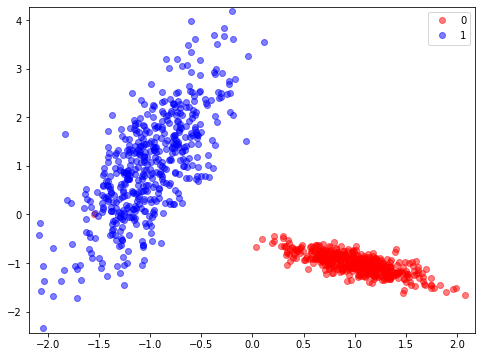

In [149]:
# Let's start with some simple linearly separable data (we use sklearn to generate the fake data):
X1, y1 = make_classification(
    n_samples=1000, 
    n_features=2, 
    n_redundant=0, 
    n_informative=2, 
    random_state=7, 
    n_clusters_per_class=1
)
plot_data(X1, y1)

LR coefficients: [[-4.07231906  2.09044633]]
LR intercept: [-0.23103502]


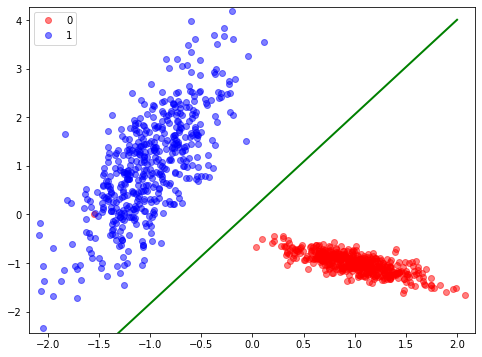

In [150]:
# For this case we don't even need networks. We can use a simple logistic regression to find the boundary:
lr = LogisticRegression(solver='liblinear')
lr.fit(X1, y1)
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

plot_data(X1, y1)

limits = np.array([-2, 2])
boundary = -(lr.coef_[0][0] * limits + lr.intercept_[0]) / lr.coef_[0][1]
plt.plot(limits, boundary, "g-", linewidth=2)

In [151]:
# The equivalent of a logistic regression in keras would be a 'network' with just 1 dense 
# layer with a binary loss function which takes the input and gives the output.
# Also, we ar enot going to split the data in train and test just to keep things simple.
model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x=X1, y=y1, verbose=0, epochs=100)
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


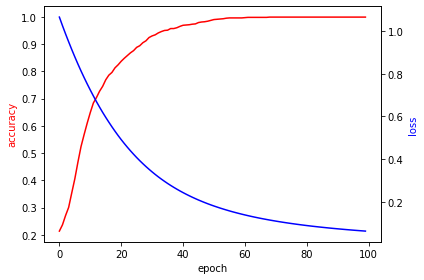

In [152]:
plot_loss_accuracy(history)

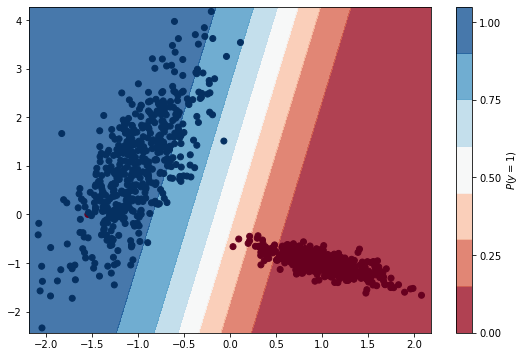

In [153]:
plot_decision_boundary(lambda x: model.predict(x), X1, y1)

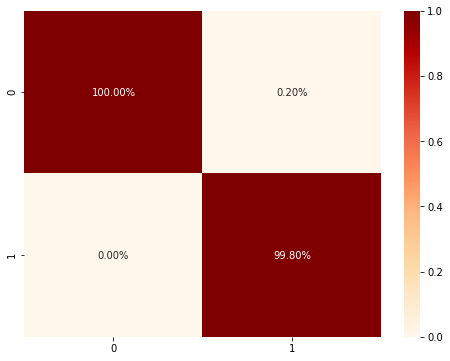

In [154]:
plot_confusion_matrix(model, X1, y1)

## Non-linearly separable data - Moons

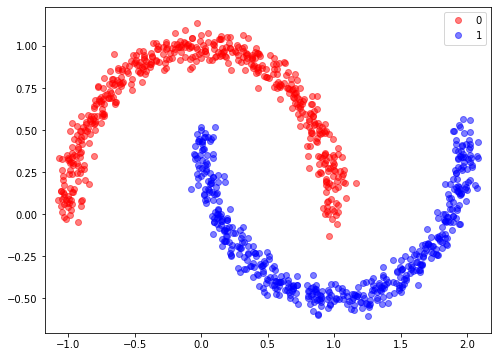

In [155]:
# Let's use some complex data:
X2, y2 = make_moons(n_samples=1000, noise=0.05, random_state=0)
plot_data(X2, y2)

In [156]:
# If we use the same linear regression model as before we expect to fail (data are not linearly separable)
model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x=X2, y=y2, verbose=0, epochs=100)

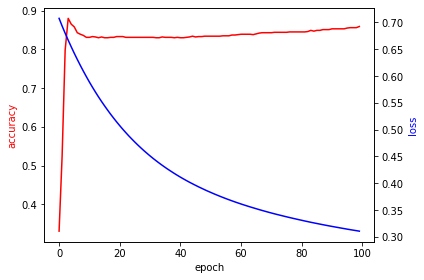

In [157]:
plot_loss_accuracy(history)

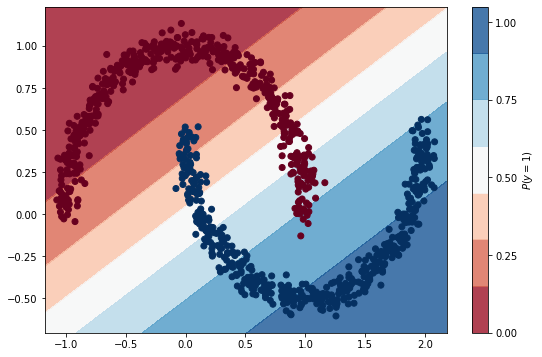

In [158]:
plot_decision_boundary(lambda x: model.predict(x), X2, y2)

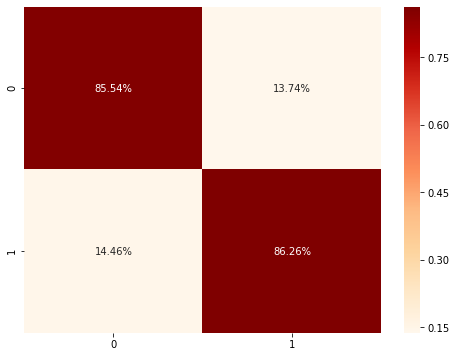

In [159]:
plot_confusion_matrix(model, X2, y2)

In [160]:
# As expected, not the best classification...

## Non-linearly separable data - Circles

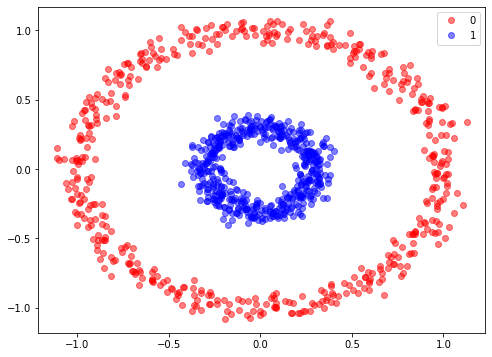

In [161]:
# We can be even nastier using circles:
X3, y3 = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)
plot_data(X3, y3)

In [162]:
model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x=X3, y=y3, verbose=0, epochs=100)

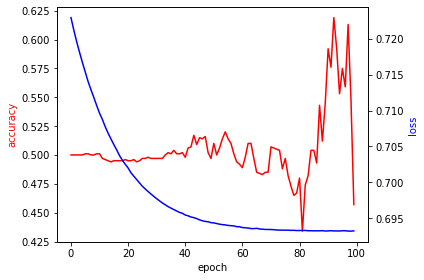

In [163]:
plot_loss_accuracy(history)

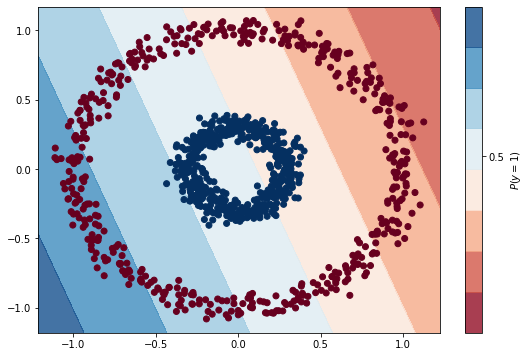

In [164]:
plot_decision_boundary(lambda x: model.predict(x), X3, y3)

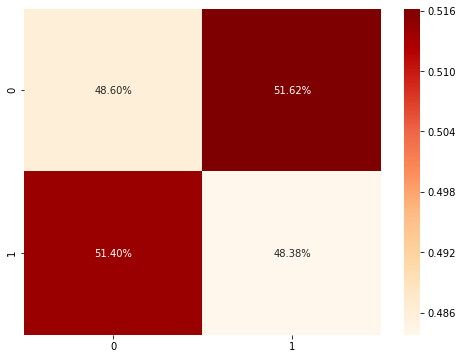

In [165]:
plot_confusion_matrix(model, X3, y3)

In [166]:
# The model is really confused (pun intended).

# Diving DEEP

In [167]:
# In order to classify non-linearly separable data we need a deep network capable of grasping the non-linearity
# we use tanh as activation because it's zero-centered (otherwise it's like a sigmoid)
model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X2, y2, verbose=0, epochs=100)
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_57 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 3         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


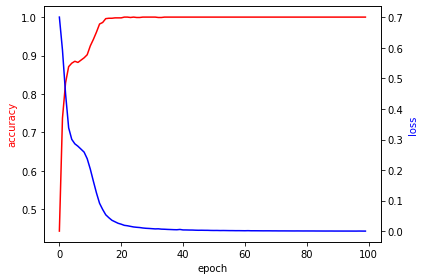

In [168]:
plot_loss_accuracy(history)

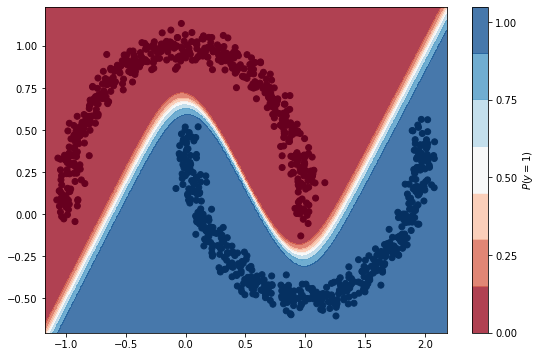

In [169]:
plot_decision_boundary(lambda x: model.predict(x), X2, y2)

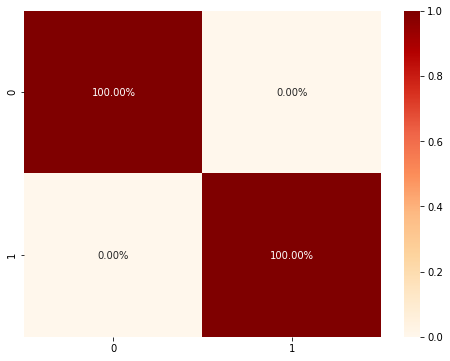

In [170]:
plot_confusion_matrix(model, X2, y2)

In [171]:
# We achieved 100% correct classification with just a 3-dense-layers network !

In [172]:
# Waht about circles ?
model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X3, y3, verbose=0, epochs=100)
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_60 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 3         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


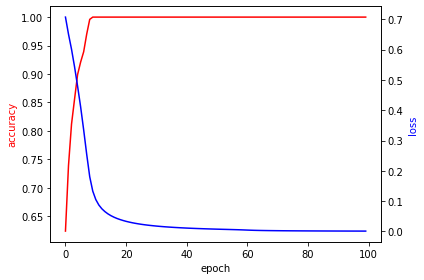

In [173]:
plot_loss_accuracy(history)

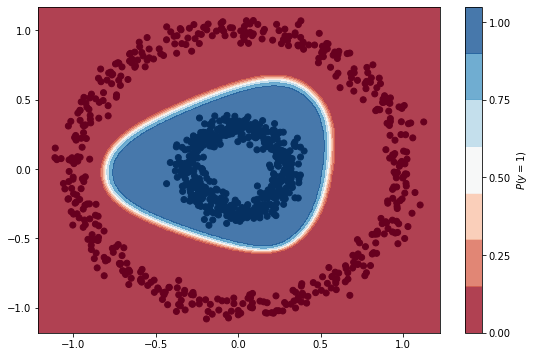

In [174]:
plot_decision_boundary(lambda x: model.predict(x), X3, y3)

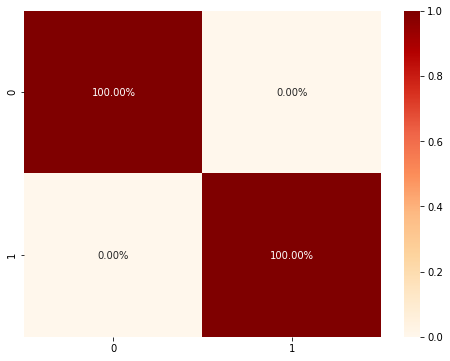

In [175]:
plot_confusion_matrix(model, X3, y3)

In [176]:
# 100% accuracy again ! :D

## Data with complex and non continuous boundaries - Sine wawe

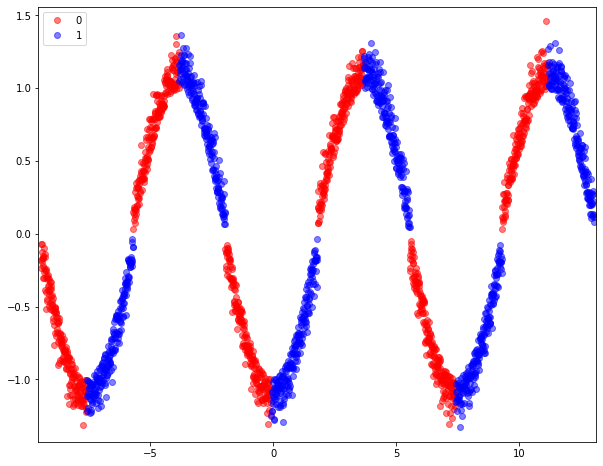

In [177]:
# Now let's try a very complex shape for the boundary
X4, y4 = make_sine_wave()
plot_data(X4, y4, figsize=(10, 8))

In [178]:
model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X4, y4, verbose=0, epochs=100)
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_63 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 3         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


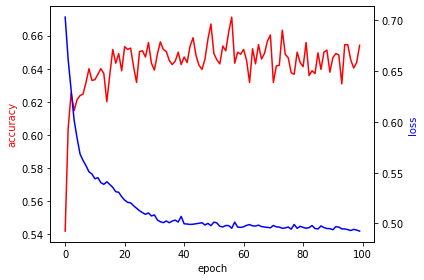

In [179]:
plot_loss_accuracy(history)

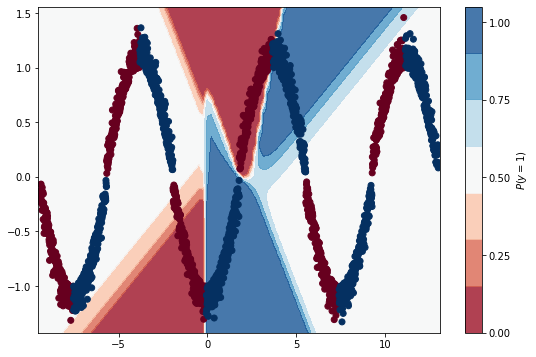

In [180]:
plot_decision_boundary(lambda x: model.predict(x), X4, y4)

In [181]:
# We need to go deeper.... Let's add one more hidden layer and let's increase the nodes for better learning
model = Sequential()
model.add(Dense(64, input_shape=(2,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X4, y4, verbose=0, epochs=100)
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_66 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_67 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 65        
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
_________________________________________________________________


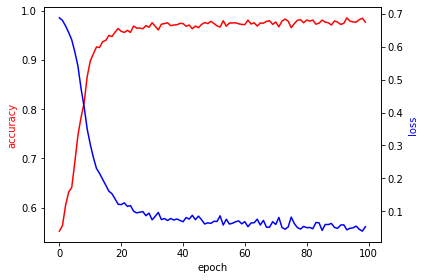

In [182]:
plot_loss_accuracy(history)

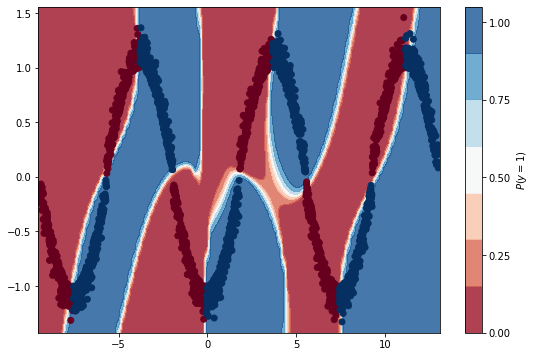

In [183]:
plot_decision_boundary(lambda x: model.predict(x), X4, y4)

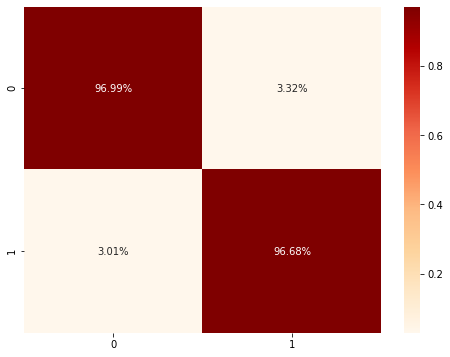

In [184]:
plot_confusion_matrix(model, X4, y4)

In [185]:
# Here we are !

## Multiclass classification

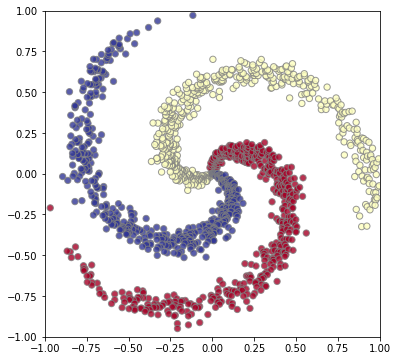

In [186]:
# We have shown the capabilites of deep networks for binary classification but everything said can be extended
# to an arbitrary number of classes. Let's demonstrate it with a 3-classes complex data:
X5, y5 = make_multiclass(K=3)

In [187]:
# Because the output is no more binary, we have to use a softmax activation for the (only) output layer
# as well ass categorical cross entropy as loss.
# The equivalent of a linear (multiclass) classifier (which we expect is not going to work) would be:
model = Sequential()
model.add(Dense(3, input_shape=(2,), activation='softmax'))

model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

y_cat = to_categorical(y5)
history = model.fit(X5, y_cat, verbose=0, epochs=100)

model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


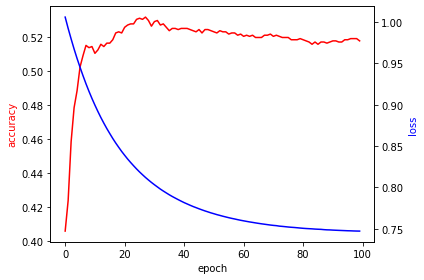

In [188]:
plot_loss_accuracy(history)

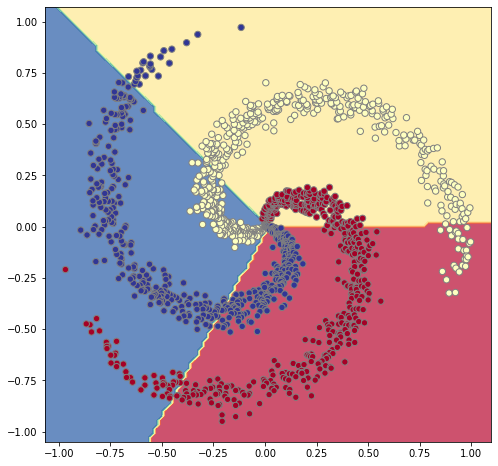

In [189]:
plot_multiclass_decision_boundary(model, X5, y5)

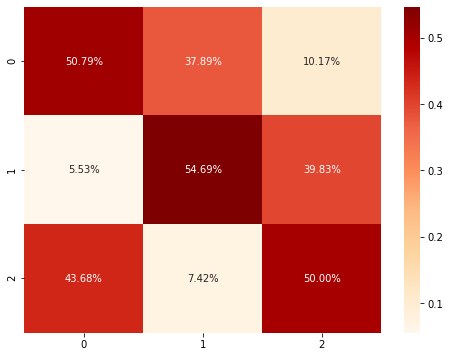

In [190]:
# A linear classifier won't grasp the non-linearity of the boundaries, as expected
plot_confusion_matrix(model, X5, y5)

In [191]:
# Once again, let's dive deeper...
model = Sequential()
model.add(Dense(128, input_shape=(2,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(64, activation='tanh'))
#model.add(Dense(16, activation='tanh'))
model.add(Dense(3, activation='softmax'))

model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

y_cat = to_categorical(y5)
history = model.fit(X5, y_cat, verbose=0, epochs=100)
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_71 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_72 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_73 (Dense)             (None, 3)                 195       
Total params: 12,995
Trainable params: 12,995
Non-trainable params: 0
_________________________________________________________________


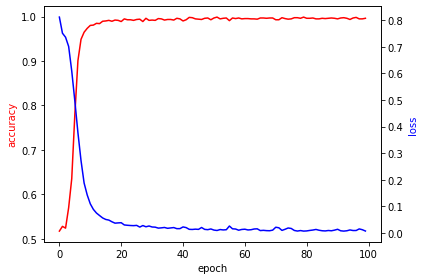

In [192]:
plot_loss_accuracy(history)

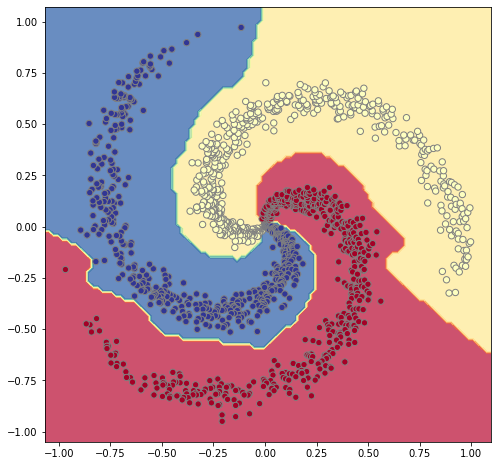

In [193]:
plot_multiclass_decision_boundary(model, X5, y5)

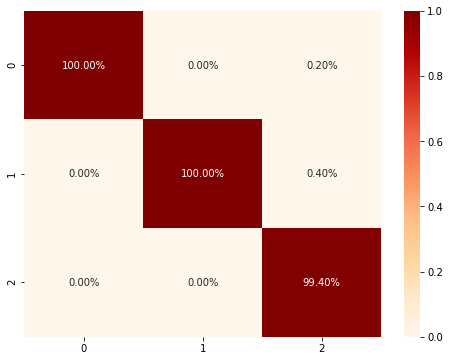

In [194]:
plot_confusion_matrix(model, X5, y5)

In [195]:
# And here we are again ! :D